Check conflict in nurse preference dataset

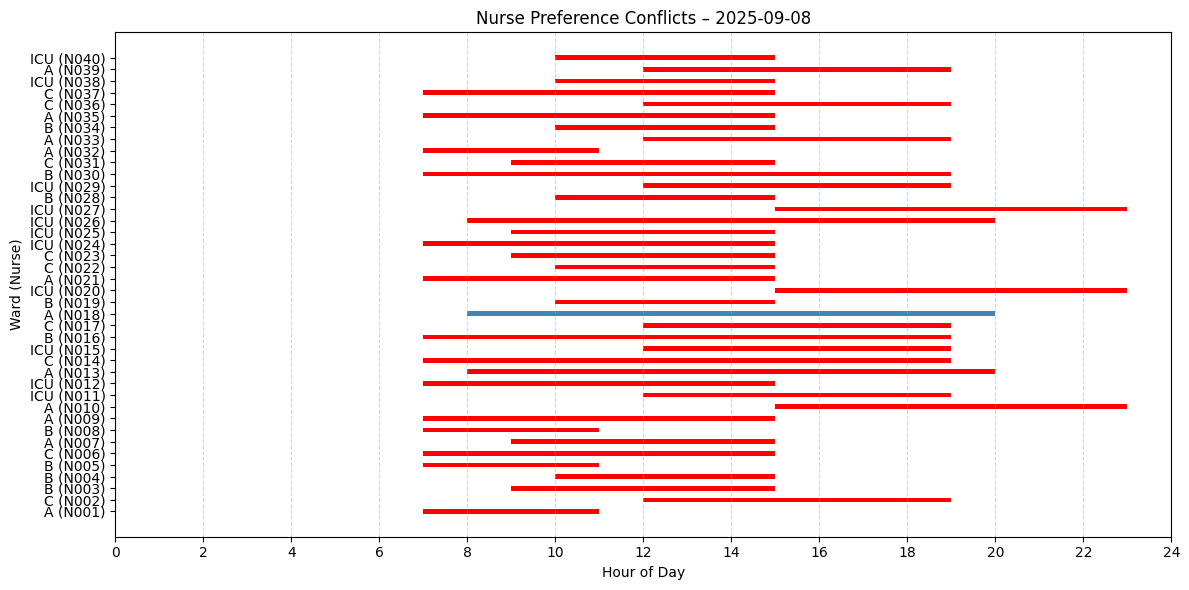

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Load dataset
df = pd.read_csv("C:\\Users\\Alex\\nurse\\data\\preference_next4weeks_full.csv")
df['date'] = pd.to_datetime(df['date'])

# Fix: Ensure time strings are in hh:mm:ss format
df['start_time'] = df['start_time'].astype(str).apply(lambda x: x if len(x) == 8 else x + ":00")
df['end_time'] = df['end_time'].astype(str).apply(lambda x: x if len(x) == 8 else x + ":00")

df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

# Choose a busy date
sample_day = df['date'].value_counts().idxmax()
day_df = df[df['date'] == sample_day].copy()

# Detect inter-nurse conflicts (same ward, overlapping time)
day_df['conflict'] = False
for ward in day_df['preferred_ward'].unique():
    ward_df = day_df[day_df['preferred_ward'] == ward].sort_values(by='start_time')
    for i in range(1, len(ward_df)):
        if ward_df.iloc[i]['start_time'] < ward_df.iloc[i-1]['end_time']:
            day_df.loc[ward_df.index[i], 'conflict'] = True
            day_df.loc[ward_df.index[i-1], 'conflict'] = True

# Plot
plt.figure(figsize=(12, 6))
for _, row in day_df.iterrows():
    color = 'red' if row['conflict'] else 'steelblue'
    plt.barh(
        y=f"{row['preferred_ward']} ({row['nurse_id']})",
        width=(row['end_time'] - row['start_time']).total_seconds() / 3600,
        left=row['start_time'].total_seconds() / 3600,
        color=color,
        height=0.4
    )

plt.title(f"Nurse Preference Conflicts – {sample_day.strftime('%Y-%m-%d')}")
plt.xlabel("Hour of Day")
plt.ylabel("Ward (Nurse)")
plt.xlim(0, 24)
plt.xticks(range(0, 25, 2))
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
